In a nutshell:

1. There 4 dimensional (4 feature) numerical inputs (signatures) with labels!
2. We need a simple model that takes these inputs and labels them (Virus, Not a Virus)
3. We also need you to evaluate your model. Choose any metric you want, but don't forget to explain why, since I don't know much about this field (that is why we need your help!)

Things to keep in mind:

- There are less 'Virus' in the dataset than 'Not a Virus'. (Naturally!)
- While we call it MAGIC, it still sometimes doesn't work well 🤦‍, so there are signatures with missing features (missing values).
- I don't know much about these things so please show your work, your thinking process and please make it as clear as possible, otherwise I get confused 😵. (Visualizations of the data and comments in your code would be great!)

Let me describe the dataset, and you are ready to get to work!
- It is a CSV file. Each row represents a signature for an app. First 4 columns from left to right represent dimensions (features) and the last column is the label (isVirus: True or False).

1. Visualize the data (so that people like me can understand!)
2. Clean up the data (balance it out, impute missing values and so on... depending on the method you are going to use!)
3. Visualize the cleaned data (so that people like me can understand the effect of cleaning process!)
4. Create a simple model that performs reasonably well. (If it doesn't perform well, comment on why and how to improve it!)
5. Evaluate the model with a testset you will create from the dataset. (Pretty plots make things easier to understand)
6. Upload your code to a private github repo you can share with us, and invite us (https://github.com/alpsina, https://github.com/ltc0060 and https://github.com/ahmetkoklu) as collaborators so only we can see our super-secret project.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Importing Data

In [3]:
raw_df = pd.read_csv('dataset.csv')
df = raw_df.copy()
df.head()

,feature_1,feature_2,feature_3,feature_4,isVirus
0,-0.233467,0.308799,2.484015,1.732721,False
1,1.519003,1.238482,3.344450,0.783744,False
2,0.400640,1.916748,3.291096,-0.918519,False
3,-1.616474,0.209703,1.461544,-0.291837,False
4,1.480515,5.299829,2.640670,1.867559,True


# Exploring and Visualizing Data

In [3]:
#Checking dataframe shape. How many observations we have and how many columns we have.

df.shape

(1999, 5)

In [4]:
#Checking feature's datatypes, observations more detailed.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  1897 non-null   float64
 1   feature_2  1899 non-null   float64
 2   feature_3  1893 non-null   float64
 3   feature_4  1897 non-null   float64
 4   isVirus    1999 non-null   bool   
dtypes: bool(1), float64(4)
memory usage: 64.5 KB


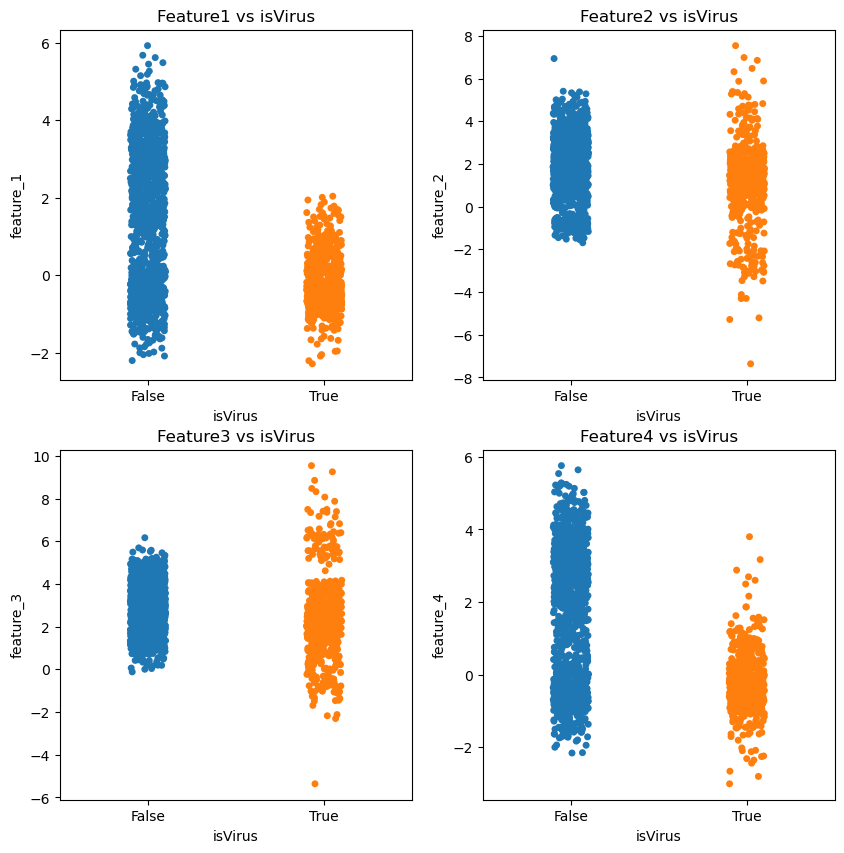

In [5]:
# Creating a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Creating a scatterplot of isVirus vs feature1 in the first subplot
sns.stripplot(data = df, x = "isVirus", y = "feature_1", ax = axs[0, 0])

# Create a histogram of isVirus vs feature2 in the second subplot
sns.stripplot(data = df, x = "isVirus", y = "feature_2", ax = axs[0, 1])


# Creating a scatterplot of isVirus vs feature3 in the third subplot
sns.stripplot(data = df, x = "isVirus", y = "feature_3", ax = axs[1, 0])


# Creating a scatterplot of isVirus vs feature4 in the fourth subplot
sns.stripplot(data=df, x="isVirus", y="feature_4", ax = axs[1, 1])

# Set titles for the subplots
axs[0, 0].set_title('Feature1 vs isVirus')
axs[0, 1].set_title('Feature2 vs isVirus')
axs[1, 0].set_title('Feature3 vs isVirus')
axs[1, 1].set_title('Feature4 vs isVirus')

# Show the figure
plt.show()

### Findings:
- Feature1 is tend to be **False/nonVirus**
- Feature2 is tend to be **True/Virus**
- Feature3 is tend to be **True/Virus**
- Feature4 is tend to be **False/nonVirus**

1. So what about relationships between these 4 features? 
2. Do they tend to be together or vice versa?

In [6]:
#Checking Correlations between variables.

df.corr()

,feature_1,feature_2,feature_3,feature_4,isVirus
feature_1,1.000000,0.427723,0.128848,0.787798,-0.440070
feature_2,0.427723,1.000000,0.144642,0.437098,-0.274508
feature_3,0.128848,0.144642,1.000000,0.133725,-0.114877
feature_4,0.787798,0.437098,0.133725,1.000000,-0.437475
isVirus,-0.440070,-0.274508,-0.114877,-0.437475,1.000000


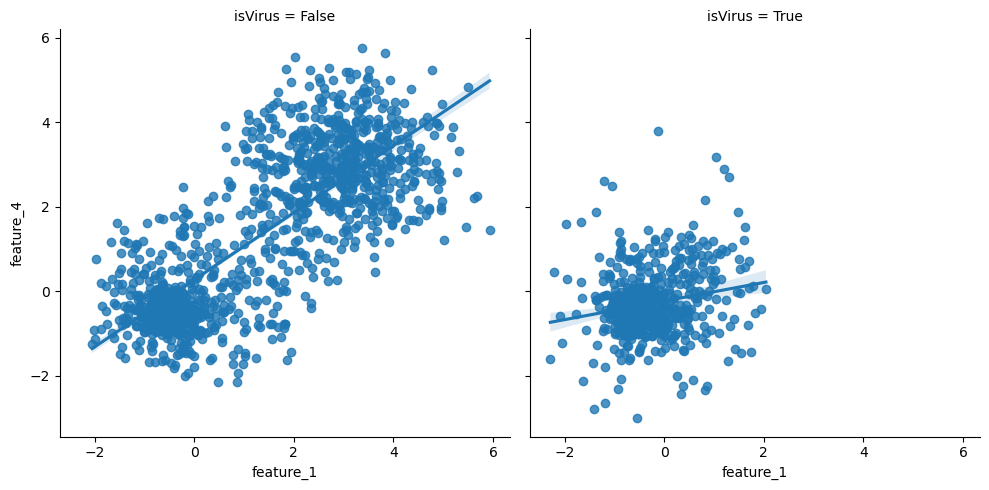

In [7]:
#The relationship graph between 2 variables and the target variable

sns.lmplot(x = 'feature_1', y = 'feature_4' , col = 'isVirus', data=df);

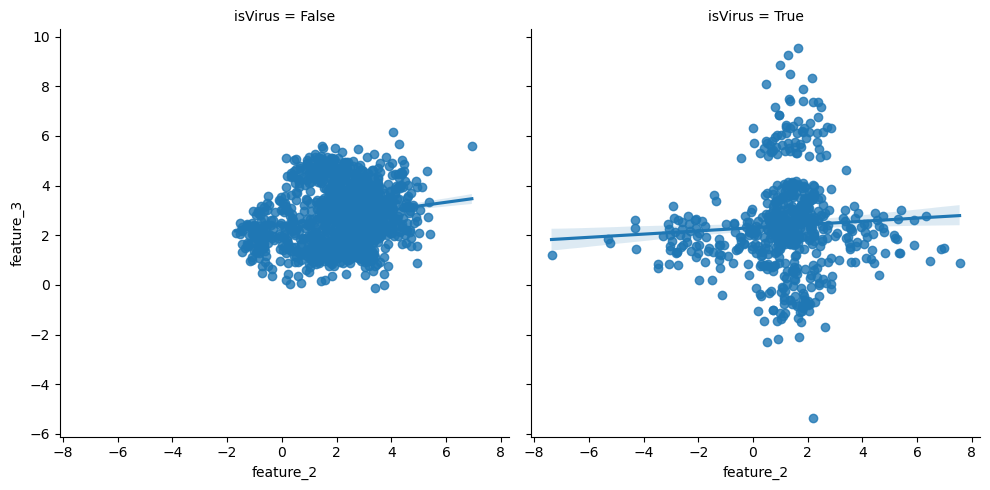

In [8]:
#The relationship graph between another 2 variables and the target variable

sns.lmplot(x = 'feature_2', y = 'feature_3' , col = 'isVirus', data=df);

### Findings:

- According to the 4 strip plot, we can see there must be some relationships with the same tending types.
- With this vision we can check it out with scatter plots with a regression line.
- We can validate when feature_1 is increasing and feature_2 is increasing too and both of them are related with False output in the starting points and ending points of the line.
- But we can not say the same things for feature_2 and feature _3. In both parts, there is no strong relationship with false and True. One more thing is interesting too which is the False part of 2 and 3. Because almost the same values for both features make False output.

In [9]:
# Aggregation structures of out dataset.

df.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,1897.0,0.814404,1.729538,-2.285499,-0.556433,0.084789,2.270955,5.929096
feature_2,1899.0,1.795843,1.605611,-7.363119,0.975148,1.881904,2.840511,7.549658
feature_3,1893.0,2.621096,1.474973,-5.363119,1.671905,2.499623,3.470200,9.549658
feature_4,1897.0,0.807499,1.768597,-3.006499,-0.563357,0.021857,2.319822,5.759355


### **- We saw that actually we have missing values from df.info(). Let's look at how many missing values we have of each feature.**

In [10]:
#Checking feature's missing values.

df.isnull().sum()

feature_1    102
feature_2    100
feature_3    106
feature_4    102
isVirus        0
dtype: int64

### - We can visualize them of course.

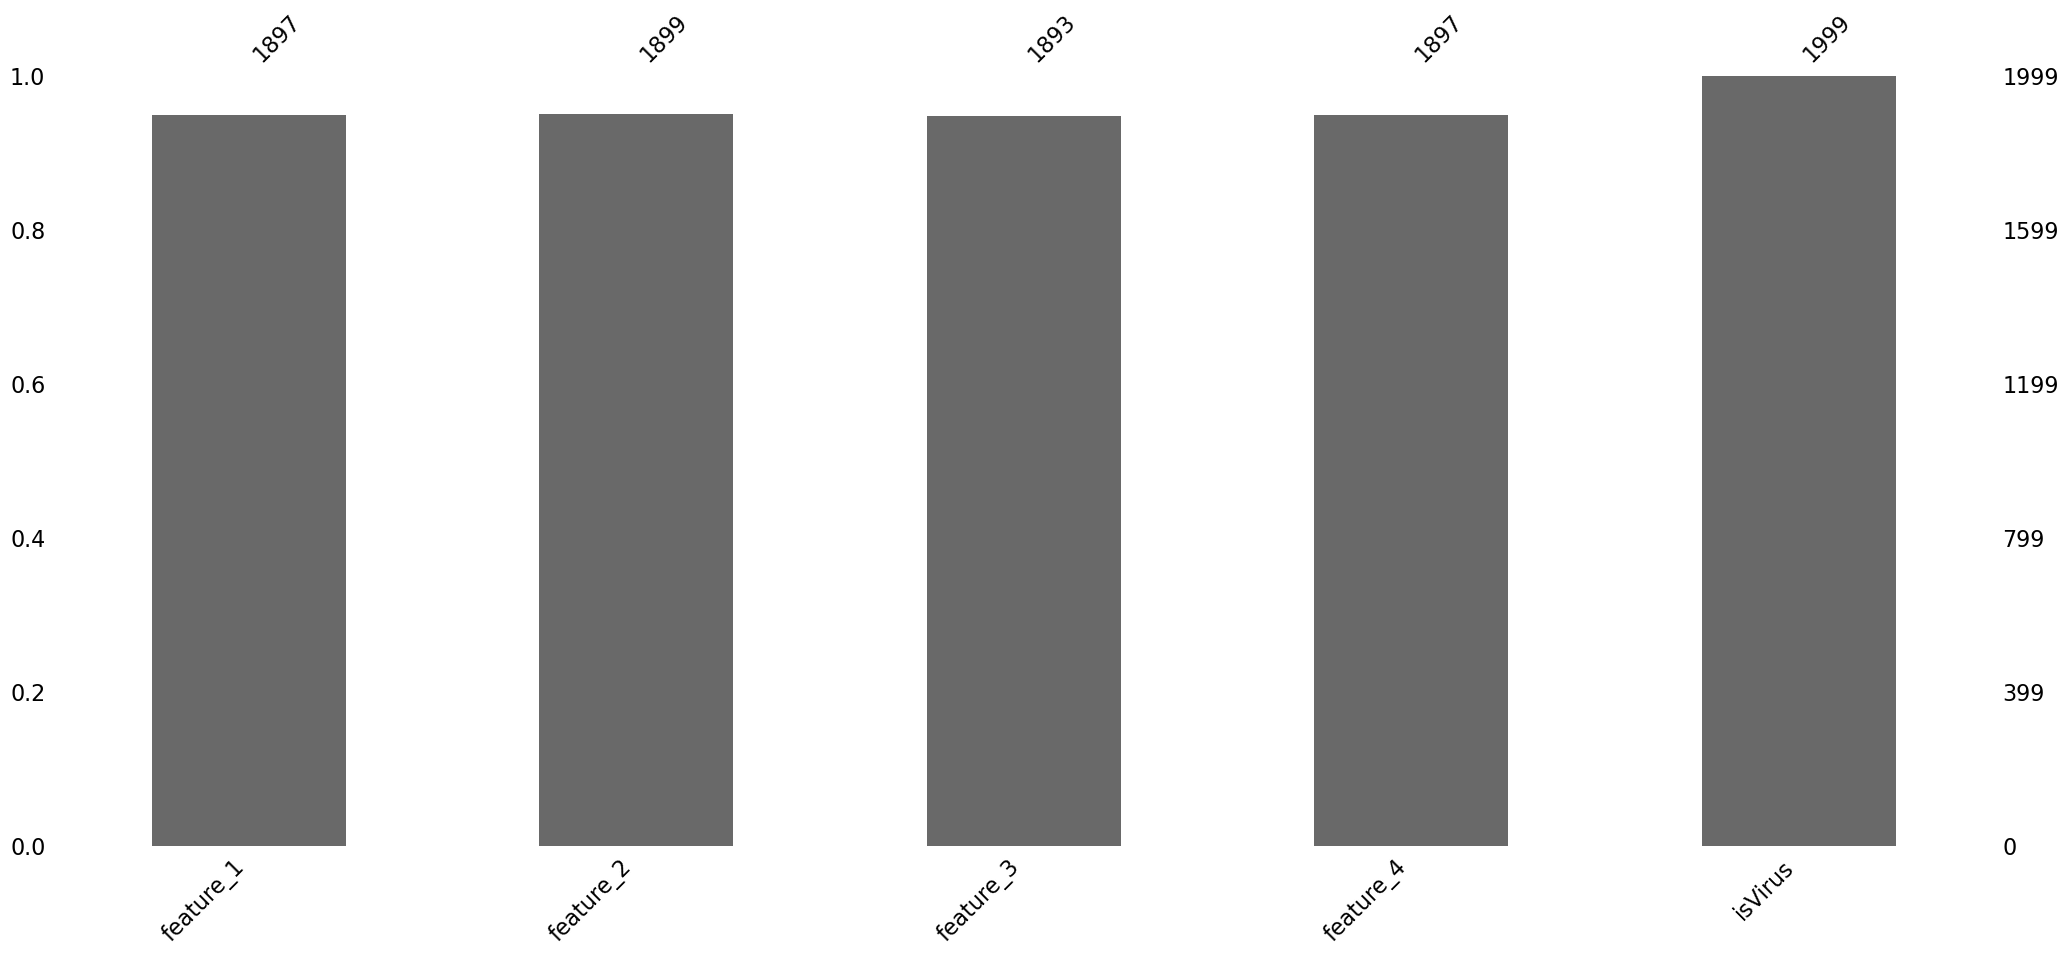

In [11]:
# Feature's missing values graphs

msno.bar(df);

### - Are there any relationships between feature's missing values?

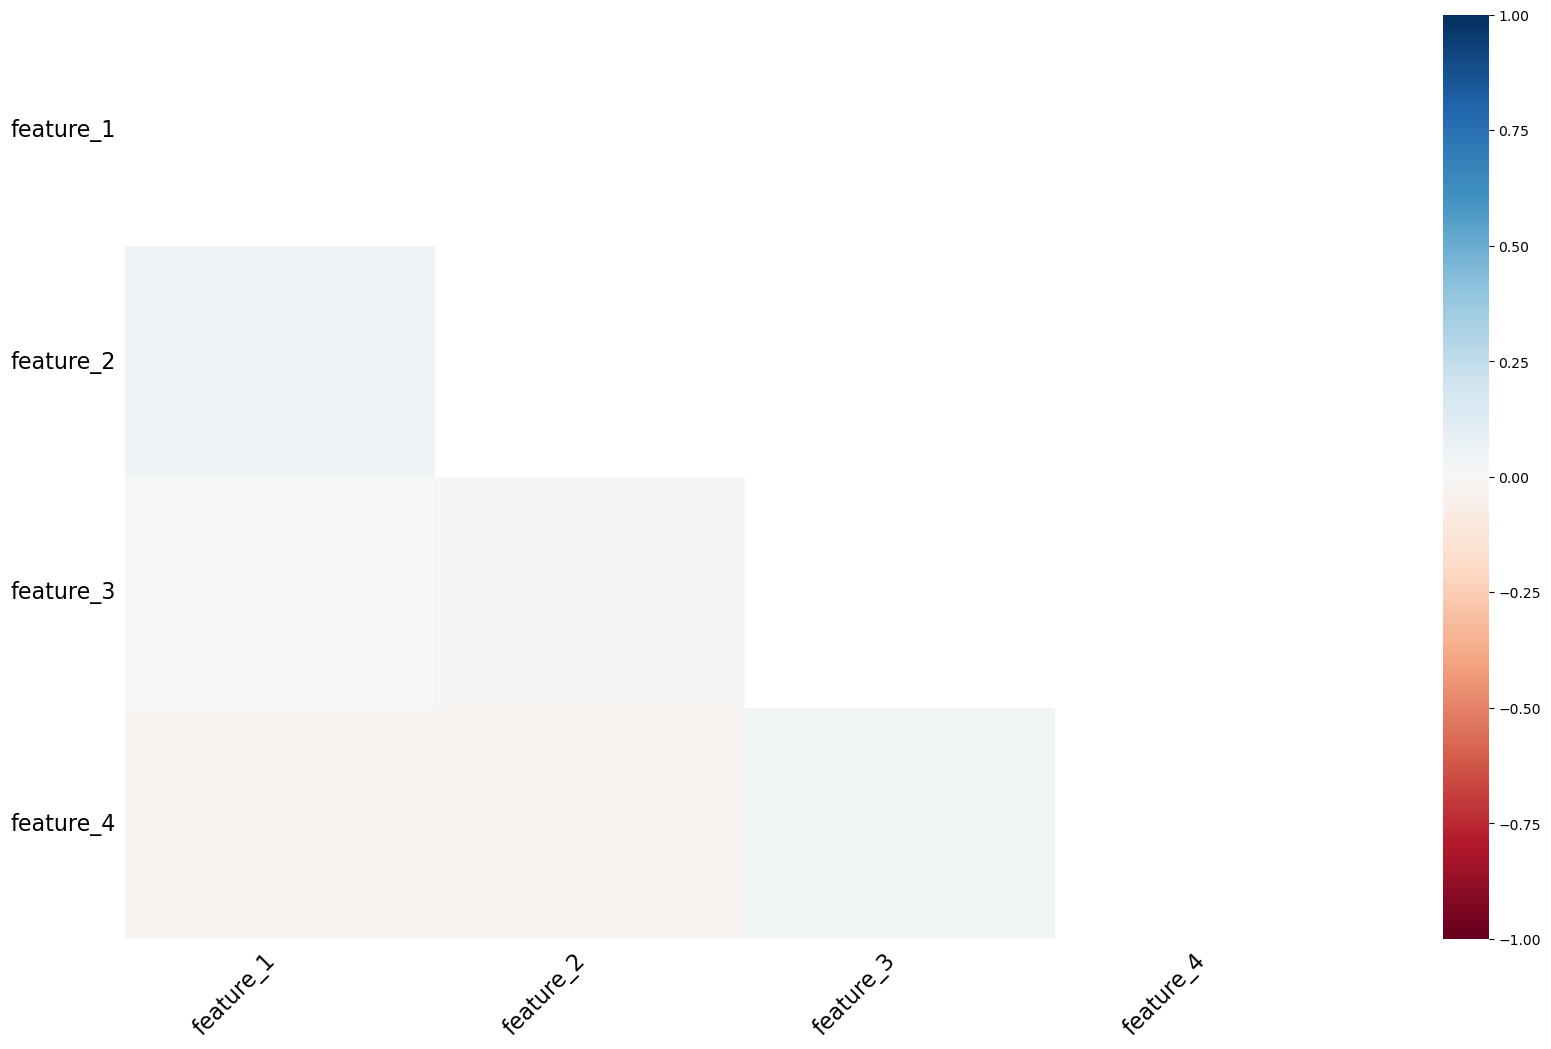

In [12]:
#Feature's missing values relatiopnships heatmap.

msno.heatmap(df);

### - Completely clean. There are no relationships between any features.
#### What about the outliers?

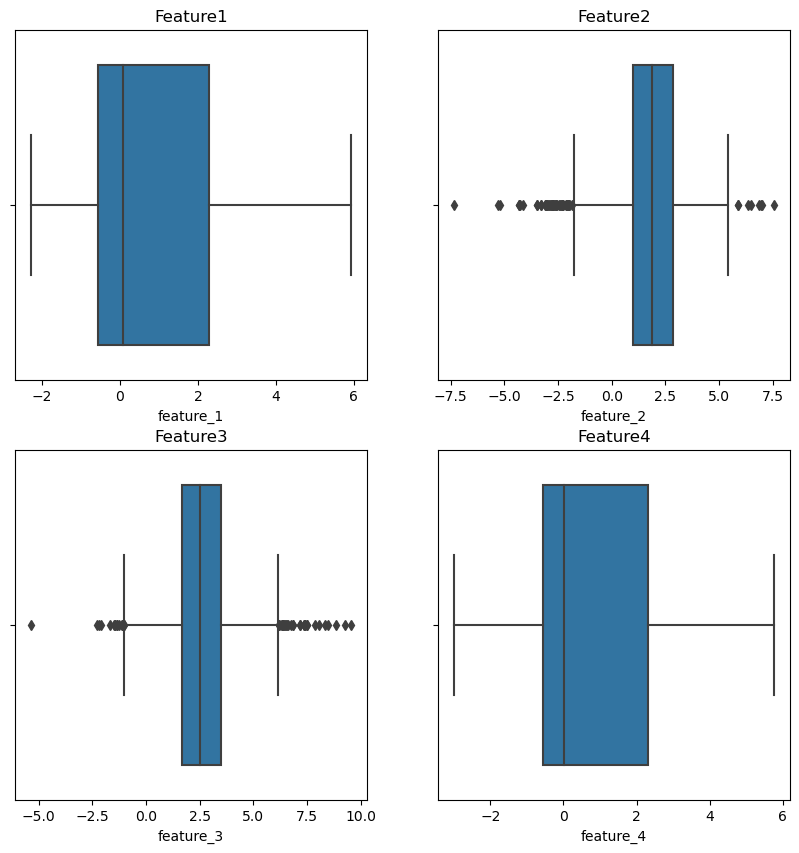

In [13]:
# Creating a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Creating a scatterplot of isVirus vs feature1 in the first subplot
sns.boxplot(x = df['feature_1'], ax = axs[0, 0])

# Create a histogram of isVirus vs feature2 in the second subplot
sns.boxplot(x = df['feature_2'], ax = axs[0, 1])


# Creating a scatterplot of isVirus vs feature3 in the third subplot
sns.boxplot(x = df['feature_3'], ax = axs[1, 0])


# Creating a scatterplot of isVirus vs feature4 in the fourth subplot
sns.boxplot(x = df['feature_4'], ax = axs[1, 1])

# Set titles for the subplots
axs[0, 0].set_title('Feature1')
axs[0, 1].set_title('Feature2')
axs[1, 0].set_title('Feature3')
axs[1, 1].set_title('Feature4')

# Show the figure
plt.show()

### Findings:

- Feature_1 and Feature_4 are right skewed and have no outliers.
- Feature_2 and Feature_3 have no skewness and they have outliers.
- In Feature_2 and Feature_3 there are some outliers but I do not want to detect and delete these outliers. Because this is not an age feature or something like that. We do not know how these parameters works so these outliers may change reaction of output. Moreover, maybe each feature be a symbol of unique transaction.

### Last but not least, let's check out our target column.

In [14]:
# Target column's classes and their values.

df['isVirus'].value_counts()

False    1332
True      667
Name: isVirus, dtype: int64

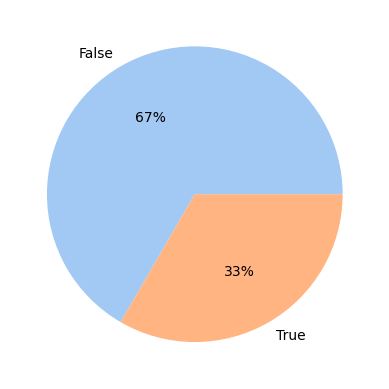

In [5]:
# Pie chart for target column's classes and their values.

labels = ['False', 'True']

colors = sns.color_palette('pastel')[0:7]

plt.pie(raw_df["isVirus"].value_counts(), labels = labels, colors = colors, autopct='%.0f%%')


plt.show()

### Findings:

- We have an imbalanced data set.
- Approximately 2:1 ratio is too much.
- From past experiences, used SMOTE technique but it improved recall but it cost too much about precision and f1-score. This time mayve we can use another method.

# Data Preprocessing

**Said that maybe every feature symbolizes a unique transaction. Want to check it out, are there any duplicate values?**

In [16]:
duplicates = df.duplicated().sum()
print('Number of Duplicates:', duplicates)

Number of Duplicates: 0


### Need a percentage of missing values if they are affordable, maybe we do not need to impute them. 

In [17]:
total_na = df.isnull().sum().sort_values(ascending = False)
percent_na = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total_na, percent_na], axis = 1, keys = ['TotalNA', 'PercentNA'])
missing_data.head()

,TotalNA,PercentNA
feature_3,106,0.053027
feature_1,102,0.051026
feature_4,102,0.051026
feature_2,100,0.050025
isVirus,0,0.000000


**Approximately %20 of our data is missing so we need to impute them. In this part I will check out data skewness of features. If feature left or right skewed going to do median imputation, If feature normally distributed going to do mean imputation.**

### For feature_1 and feature_4 (Median imputation)

In [18]:
features_median = ['feature_1', 'feature_4']

# Looping through the list of features and filling missing values with the median
for feature in features_median:
    df[feature] = df[feature].fillna(df[feature].median())

### For feature_2 and feature_3 (Mean imputation)

In [19]:
features_mean = ['feature_2', 'feature_3']

# Looping through the list of features and filling missing values with the mean
for feature in features_mean:
    df[feature] = df[feature].fillna(df[feature].mean())

In [20]:
df.isnull().sum()

feature_1    0
feature_2    0
feature_3    0
feature_4    0
isVirus      0
dtype: int64

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,1999.0,0.777175,1.692448,-2.285499,-0.531888,0.084789,2.185465,5.929096
feature_2,1999.0,1.795843,1.564915,-7.363119,1.023208,1.798798,2.792420,7.549658
feature_3,1999.0,2.621096,1.435313,-5.363119,1.719963,2.595800,3.412488,9.549658
feature_4,1999.0,0.767411,1.731518,-3.006499,-0.538374,0.021857,2.177811,5.759355


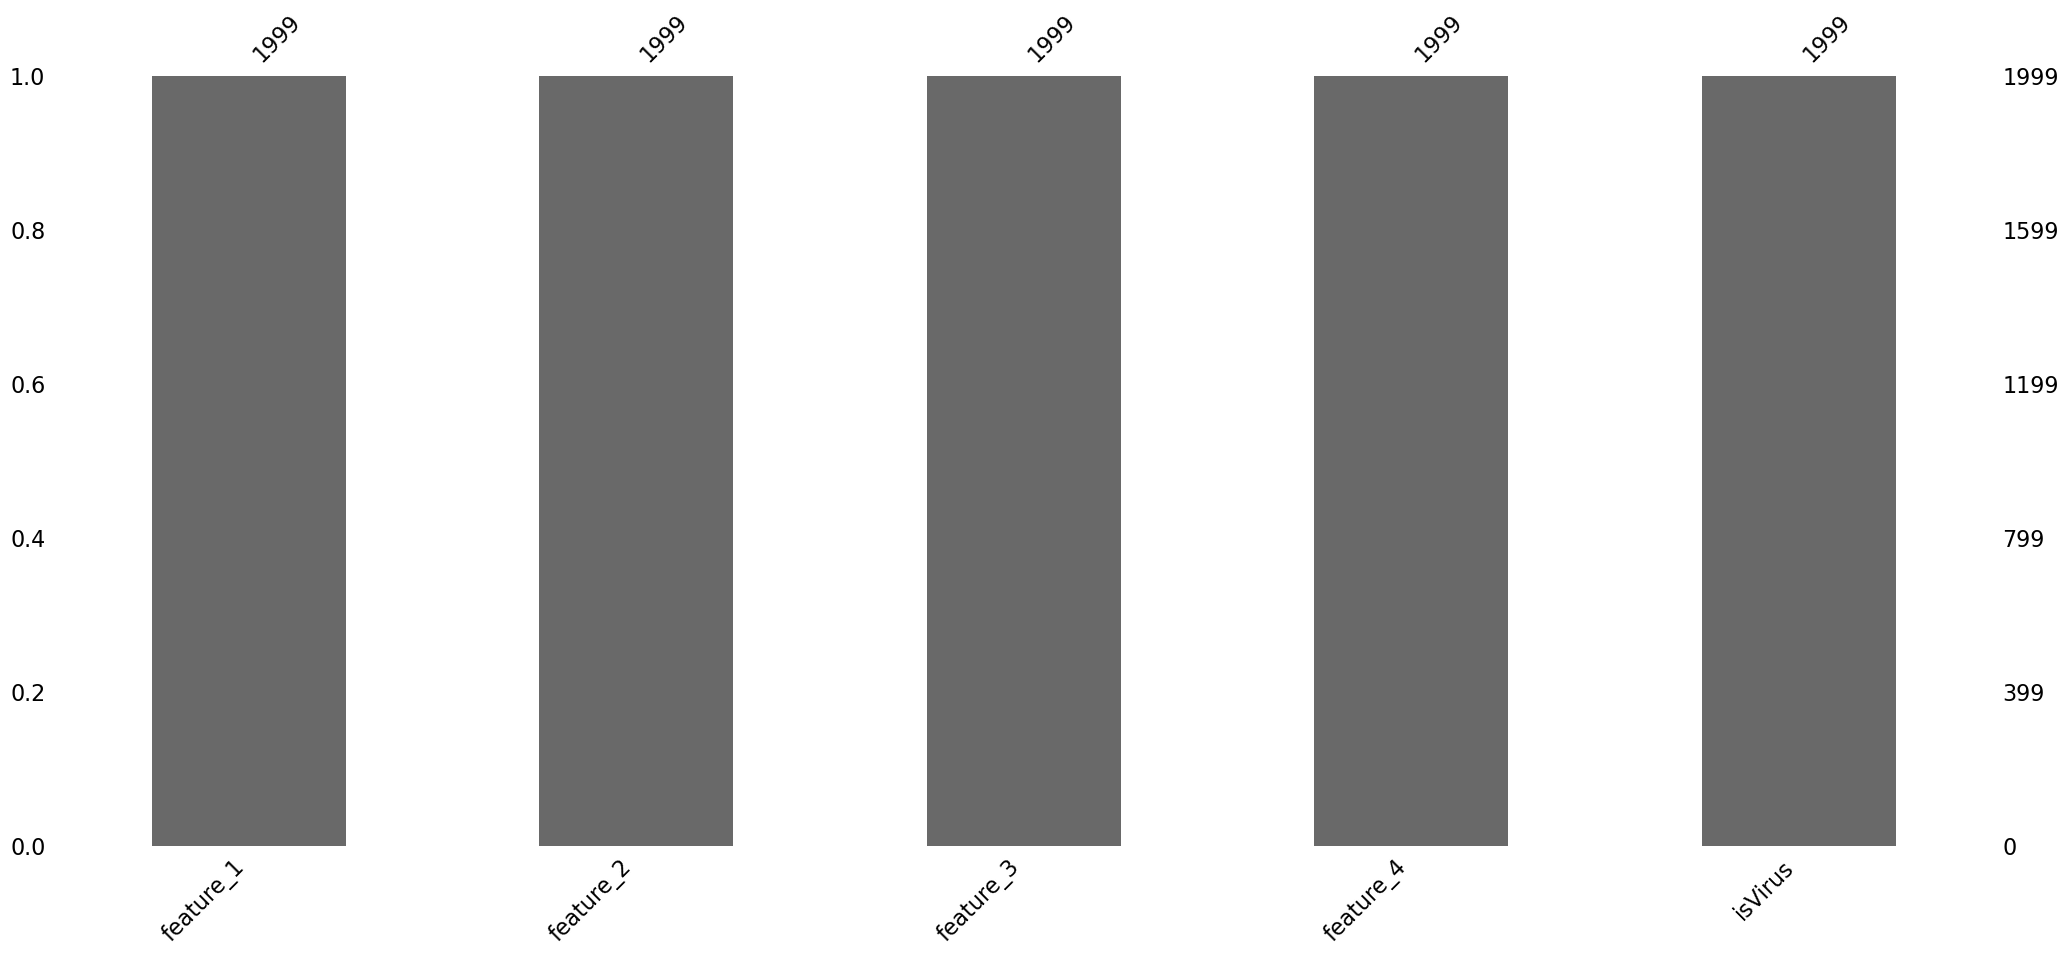

In [22]:
msno.bar(df);

### Encoding Target Column

In [23]:
# Changing target column's type boolean --> string.
df['isVirus'] = df['isVirus'].astype(str)

# Encoding True to 1 and False to 0.
df['isVirus'] = np.where(df['isVirus'].str.contains('True'), 1, 0)

df.head()

,feature_1,feature_2,feature_3,feature_4,isVirus
0,-0.233467,0.308799,2.484015,1.732721,0
1,1.519003,1.238482,3.344450,0.783744,0
2,0.400640,1.916748,3.291096,-0.918519,0
3,-1.616474,0.209703,1.461544,-0.291837,0
4,1.480515,5.299829,2.640670,1.867559,1


## Dealing with Imbalanced Dataset

### SMOTE

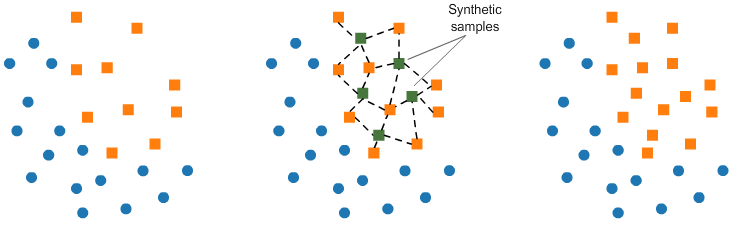

### Tomek-Links

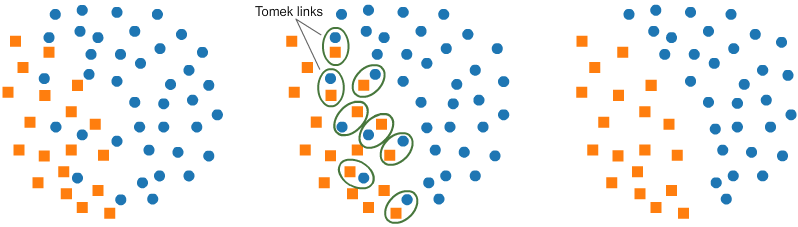

- In this section, want to introduce you to the SMOTE-Tomek Links method. In the past sections, mentioned that SMOTE(Synthetic Minority Oversampling Technique) technique is optimizing recall but very costly about f1 score and precision. On the other hand, Tomek Links is an undersampling technique. It is a great choice but we have a small amount of data, reducing data to minority class means losing so much data for modeling and predicting.
 
--> So, it's time to meet with SMOTE-TOMEK Links Method, it is combining SMOTE and Tomek Links and making more affordable solutions.

**"A combination of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance than only under-sampling the majority class. This method was first introduced by Batista et al. (2003)."**

To gain more information this is the documentation link for: 
[SMOTETOMEK](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html) 

### The process of SMOTE-Tomek Links is as follows.

1. Start of SMOTE: choose random data from the minority class.
2. Calculate the distance between the random data and its k nearest neighbors.
3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
4. Repeat step number 2–3 until the desired proportion of minority class is met (End of SMOTE).
5. Start of Tomek Links: choose random data from the majority class.
6. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.

### Important in applying part

**DO NOT RESAMPLE DATA BEFORE TRAIN-TEST-SPLIT part.**
- It is so important because if we resample all of the data first and then split them into train and test sets. This will cause an overestimation of model performance because we have altered the original distribution of classes in your test set and it is not representative of the original problem anymore.

**So, we need to do first train-test-split, after resample only train data and  leave the testing data in its original distribution in order to get a valid approximation of how our model will perform on the original data, which is representing the situation in production.**

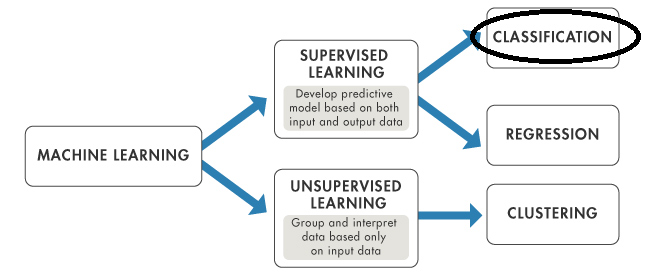

### Choosing Algorithm for Classification

- So we have labeled features and labeled target data. --> It means we should use supervised learning approaches.
- We have 2 classes target column True/False --> It means we should use binary classification models under supervised learning approaches.
There are a lot of choices in classification models. From the EDA part and depending on my past experiences, I thought KNN would be the right choice for this problem but we can go beyond this classic method. I mean KNN is a great algorithm but let's look at different aspects of this problem. These transactions are unique and maybe we won't put these transactions to common groups or nearest positions. 

**We should use some algorithm which brings us:**
1. Less prone to overfitting. -->
2. Outliers have minimal impact. --> Because we have outliers and we want to have minimal impact from them.
3. Good Execution speed --> Because I have mid-level hardware.
4. Good model performance --> Because we need a sustainable model.
5. It could be decision tree based or gradient boosting based.

**With these needs, we can choose XGBoost algorithm.**
- To gain more information this is the documantation link for: 
[XGBOOST](https://xgboost.readthedocs.io/en/stable/)

## Train-Test-Split

In [24]:
X = df.drop('isVirus', axis=1)
y = df['isVirus']

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1399, 4)
(1399,)
(600, 4)
(600,)


In [27]:
#Initializing SMOTETomek object

smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

In [28]:
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

In [29]:
print(X_train_res.shape)
print(y_train_res.shape)

(1841, 4)
(1841,)


## XGBOOST

In [30]:
#Initializing XGBoost Classifier

xgb_clf = XGBClassifier()

xgb_clf.fit(X_train_res, y_train_res)
y_pred = xgb_clf.predict(X_test)

In [31]:
cm = confusion_matrix(y_test, y_pred)

xgb_clf_Recall = recall_score(y_test, y_pred)
xgb_clf_Precision = precision_score(y_test, y_pred)
xgb_clf_f1 = f1_score(y_test, y_pred)
xgb_clf_accuracy = accuracy_score(y_test, y_pred)

In [32]:
df_xgbm = [(xgb_clf_Recall, xgb_clf_Precision, xgb_clf_f1, xgb_clf_accuracy)]

xgb_clf_score = pd.DataFrame(data = df_xgbm, index = ['XGBOOST'], columns=['Recall','Precision','F1 Score', 'Accuracy'])
xgb_clf_score

,Recall,Precision,F1 Score,Accuracy
XGBOOST,0.81,0.818182,0.81407,0.876667


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       400
           1       0.82      0.81      0.81       200

    accuracy                           0.88       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.88      0.88      0.88       600



In [34]:
y_probs = xgb_clf.predict_proba(X_test)[:, 1]

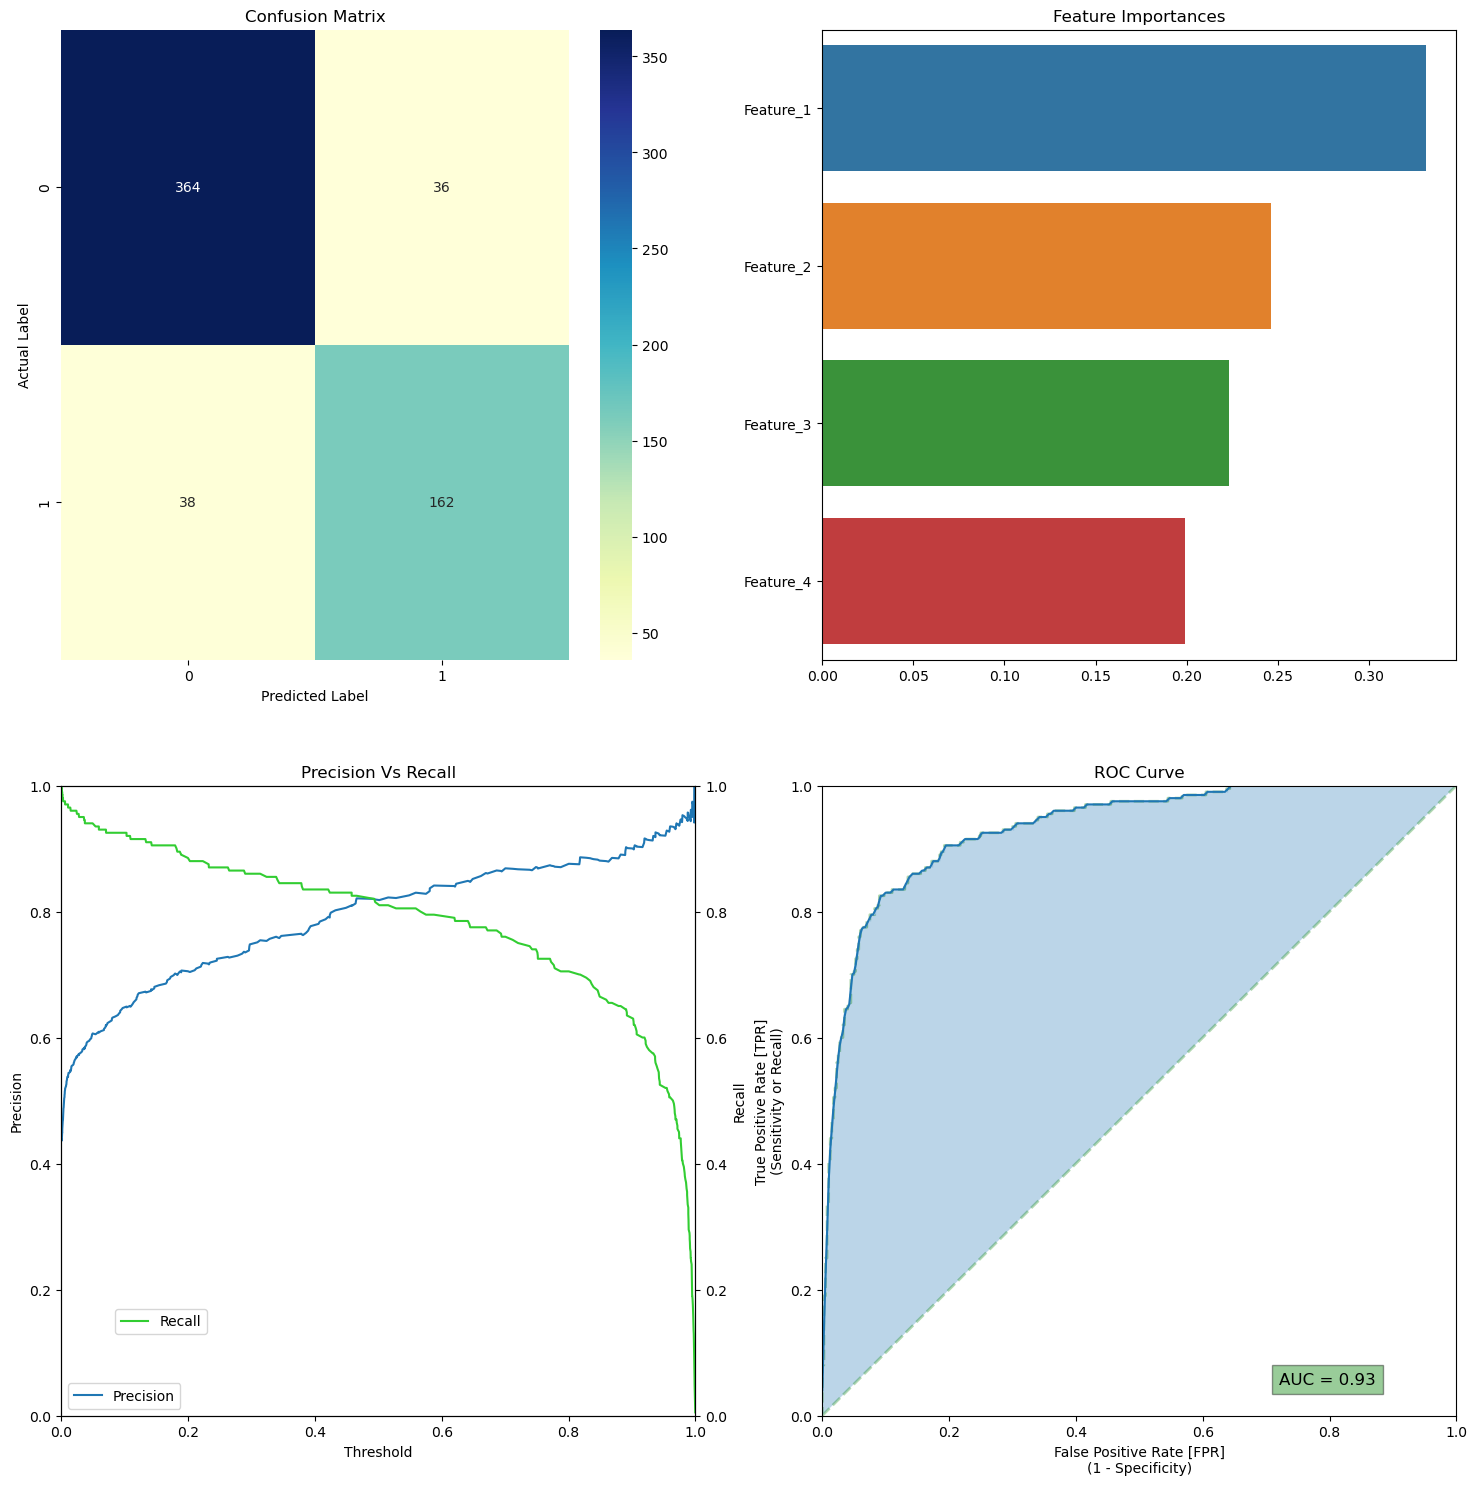

In [38]:
# Creating a figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 18))

# Creating a heatmap for classification_report
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g', ax = axs[0, 0])
axs[0, 0].set_ylabel('Actual Label')
axs[0, 0].set_xlabel('Predicted Label')
axs[0, 0].set_title('Confusion Matrix')

# Creating feature importances bar plot
importances = pd.Series(xgb_clf.feature_importances_,
                                        index=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4']) \
                                .sort_values(ascending=False)
sns.barplot(x=importances, y=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4'], ax = axs[0, 1])
axs[0, 1].set_title('Feature Importances')


# Creating a Precision-Recall plot
p, r, thresh_1 = precision_recall_curve(y_test, y_probs)
p, r, thresh_1 = list(p), list(r), list(thresh_1)
p.pop()
r.pop()
sns.lineplot(x = thresh_1, y = p, label='Precision', ax=axs[1, 0])
axs[1, 0].set_xlabel('Threshold')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(loc='lower left')

axs_twin = axs[1, 0].twinx()
sns.lineplot(x = thresh_1, y = r, color='limegreen', label='Recall', ax=axs_twin)
axs_twin.set_ylabel('Recall')
axs_twin.set_ylim(0, 1)
axs_twin.legend(bbox_to_anchor=(0.24, 0.18))
    
axs[1, 0].set_xlim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_title('Precision Vs Recall')


# Creating a ROC curve with AUC score.
fpr, tpr, thresh_2 = roc_curve(y_test, y_probs, drop_intermediate=False)
auc = round(roc_auc_score(y_test, y_probs), 2)

sns.lineplot(x=fpr, y=tpr, ax = axs[1, 1])

axs[1, 1].text(0.72, 0.05, f'AUC = { auc }', fontsize=12,
                  bbox=dict(facecolor='green', alpha=0.4, pad=5))
axs[1, 1].fill_between(fpr, fpr, tpr, alpha=0.3, edgecolor='g',
                          linestyle='--', linewidth=2)
axs[1, 1].set_xlim(0, 1)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_title('ROC Curve')
axs[1, 1].set_xlabel('False Positive Rate [FPR]\n(1 - Specificity)')
axs[1, 1].set_ylabel('True Positive Rate [TPR]\n(Sensitivity or Recall)')

# Show the figure
plt.show()

## Evaluating Results

**Terms:**
    
 - Confusion Matrix
 - Recall
 - Precision
 - F1 Score
 - ROC Curve
 - AUC Score

## Confusion Matrix

- We created a model but how can we measure the effectiveness of our model? Better the effectiveness, better for the performance and these are what we want exactly. At this time the confusion matrix runs for help. Confusion Matrix is performance measurement for machine learning classification.

- It is a table divided by 4 different combinations of predicted and actual values. It is so important for measuring Recall, Precision, F1 Score, Accuracy also important for AUC-ROC curves.

But first we need to understand what this confusion matrix is. As I mentioned before, we have 4 different combinations. I will keep it simple for you. These are:

- **True Positives:** It is in the bottom right combination of our table. It means, we predicted that it is a virus and it is true.
- **False Positives:** It is in the top right combination of our table. It means, we predicted that it is a virus but it is not true.
- **False Negatives:** It is in the bottom left combination of our table. It means, we predicted that it is not a virus but it is false. 
- **True Negatives:** It is in the top left combination of our table.It means, we predicted that it is not a virus and it is true.

-------

- **Recall:** From all the positive classes, how many we predicted correctly.
- **Precision:** From all the classes we have predicted as positive but how many are actually positive. 
-  **Accuracy:** From all the classes, how many of them we have predicted correctly.
- **F1 Score:** F-score helps us to measure Recall and Precision at the same time. At the same time, F1 Score has been designed to work well on imbalanced data which is our case.

**These 4 metrics need to be high as posible.**

**Also there is a common misunderstanding in classification models which is that accuracy is not a good metric to use when you have class imbalance. If we used resampling methods like SMOTE, TOMEK etc..These methods are inflating accuracy scores. For better understanding of our models we need to check other performance metrics.**

-------

### ROC Curve and AUC Score

- **ROC Curve:** A Receiver Operator Characteristic (ROC) curve is a graphical plot used to show the diagnostic ability of binary classifiers.Classifiers that give curves closer to the top-left corner indicate a better performance.

- **Area under curve (AUC):** AUC is the measure of the capability of a binary classifier to distinguish between classes and is used as a summary of the ROC curve.The higher the AUC, the better the model's performance at distinguishing between the positive and negative classes.

## Evaluating Results In Our Case

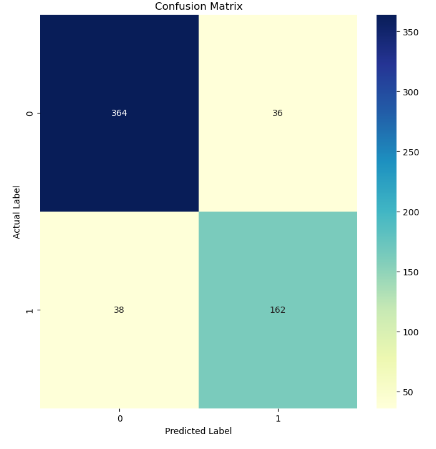

So this is our confusion matrix and the values are like this:

- **True Positives:** In 162 observations we predicted it was a virus and it was true.
- **False Positives:** In 36 observations we predicted it was a virus but it was not true.
- **False Negatives:** In 38 observations we predicted it was not a virus but it was not true.
- **True Negatives:** In 364 observations we predicted it was not a virus and it was true.

In [39]:
xgb_clf_score

,Recall,Precision,F1 Score,Accuracy
XGBOOST,0.81,0.818182,0.81407,0.876667


- As I mentioned before, accuracy must not be the only one performance metric to determine our model's performance.
- All these scores are looking great.

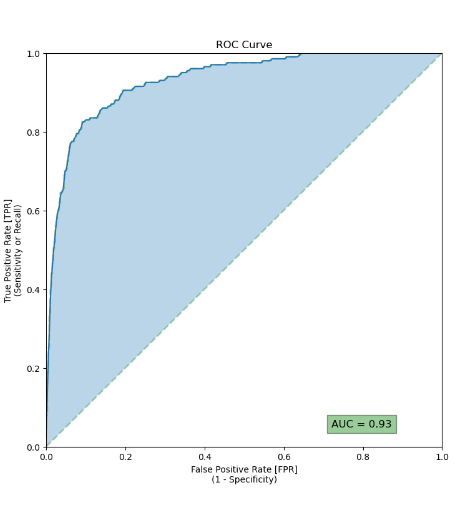

- In terms of ROC Curve: Model could be improved more. With proper hyperparameters it would be more close to the top left.
- In addition to that, our AUC score is pretty good. 

## Possible improvements and future work

Actually It is possible to go beyond this project.

1. Our model seems reasonable but maybe we have more effective models in other folds of our data. In our train-test-split part I used traditional methods for this case. This process is dividing data to train and test set but we do not know which part of our data chosen. In k-Fold Cross Validation we can divide our data into different folds and can run models in those folds to see our model's performance.
-------
2. We did not remove any outliers in Feature_2 and Feature_3 so maybe it makes sense to remove those outliers from our dataset.
-------
3. We used XGBoost in our project but we can try different classification algorithms and check how performance changes from model to model. I chose it from my past experiences but maybe other classification algorithms would make a more effective impact.
-------
4. Last but probably not least, we used XGBoost but did not make any hyperparameters selection or tuning process. It is possible to dig more deeper for hyperparameters could be very efficient but moving to this stage will make the model complicated. In order to keep our model simple I stopped in here. Also the tuning process is very costly for individual people. Conversely, there are good methods for tuning like Bayesian Search with Optuna is a great choice. On the other hand, GridSearchCV is so time consuming and costly but if you need guaranteed better performance this must be the way. In addition to these methods, RandomizedSearch is useful too but it can not guarantee the optimal result. 

## Closing Statement

Thank you for this great project. It was very interesting and fun process for me. 
Waiting feedbacks from you.

Thank you.
Warm regards.

- [Erkut Koral LinkedIN](https://www.linkedin.com/in/erkutkoral/)
- erkut.koral@gmail.com